# Unsupervised Clustering of Board Game Reviews

_Ryan Harper_

In [42]:
import random
import numpy as np
from string import punctuation as punct
import matplotlib.pyplot as plt
import seaborn as sns
import os
import operator
from math import ceil

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import v_measure_score
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec


from keras.preprocessing.sequence import pad_sequences

from IPython.display import display, Markdown, Latex

# for mac only: frog,blow,funk,glass,tink,submarine,purr,sosumi
def beep(audio): 
    os.system('afplay /System/Library/Sounds/' + audio +'.aiff')

# 1. Import and Clean Data

In [2]:
import pandas as pd

boardgamereviews = pd.read_csv('../data/boardgame/boardgame-comments-english.csv')
boardgamereviews.columns = 'reviewer_id', 'game_id', 'rating', 'comment'
unique_id = boardgamereviews.reviewer_id.unique()
sample_id = random.sample(unique_id.tolist(),100)
review = boardgamereviews[boardgamereviews['reviewer_id'].isin(sample_id)]

#### _Ratings equal the difference between a user's rating and that user's average rating._

In [3]:
review['rating_normed']=review.rating - review['rating'].groupby(review['reviewer_id']).transform('mean')
review['rating_normed']=(review['rating_normed']-review['rating_normed'].min())/(review['rating_normed'].max()-review['rating_normed'].min())
review['rating_normed']=review['rating_normed'].apply(lambda val: val*10).apply(ceil)
if 0 not in review['rating'].unique():
    review['rating_normed']=review['rating_normed'].apply(lambda val: 1 if val==0 else val)
# review['estimate'] = review['rating_normed'] + review['rating'].groupby(review['reviewer_id']).transform('mean')

In [4]:
review['rating'] = review['rating'].apply(round)

# 2. Visualize

#### _The ratings appear normalized after reviews are adjusted according to user specific ratings_

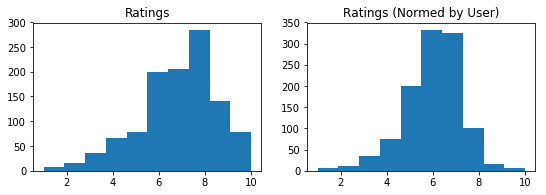

In [5]:
plt.figure(figsize=(9,6))
plt.subplot(2,2,1)
plt.hist(review.rating,bins=10)
plt.title('Ratings')

plt.subplot(2,2,2)
plt.hist(review.rating_normed,bins=10)
plt.title('Ratings (Normed by User)');

In [6]:
from math import ceil

In [7]:
review.rating_normed.apply(lambda val: val*10).apply(ceil).apply(lambda val: 1 if val==0 else val).unique()

array([ 90,  30,  70,  80,  50,  40,  60,  20, 100,  10])

# 3. Tokenize

In [8]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm

# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE|re.UNICODE)

# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

# setup tokenizer
tokenizer = WordPunctTokenizer()

vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    text = re_url.sub("URL", text)
    
    # replace IPs
    text = re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments


comments_train = list(review["comment"].fillna("NAN_WORD").values)

review['token'] = process_comments(comments_train, lower=True)

  0%|          | 0/1113 [00:00<?, ?it/s]

Processing text dataset


100%|██████████| 1113/1113 [00:00<00:00, 23502.29it/s]


In [9]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))

The vocabulary contains 5144 unique tokens


# 4. Vocab Scoring 

_CREDIT: Methodology and some code for this section closely follows Kenny Liao's Approach_

In [10]:
word_list = set([v for sublist in review.token.tolist() for v in sublist])

In [11]:
vocab_ratings = review[['rating']]
del vocab_ratings['rating']

In [12]:
for v in tqdm(word_list):
    vocab_ratings[v]=[rating if v in token else None for rating,token in review[['rating','token']].iterrows()]
#     vocab_ratings[v]=[row[1][0] if v in row[1][1] else None for row in review[['rating','token']].iterrows()]

100%|██████████| 5144/5144 [06:58<00:00, 12.29it/s]


#### Vocab Rating Baseline

In [34]:
from math import sqrt
def rmse(true, predicted):
    rmse = sqrt(((true-predicted)**2).mean())
    return rmse

Get the baseline RMSE if we just predict every comment is equal to the median for all ratings.

In [35]:
review.rating.median()

7.0

In [36]:
review['baseline'] = review.rating.median()
review.head(2)

,reviewer_id,game_id,rating,comment,rating_normed,token,baseline
137,114520,3076,9,Like New - 2-3 plays,9,"[like, new, -, 2, -, 3, plays]",7.0
540,169253,891,5,Great party game. Everyone playing has to have...,3,"[great, party, game, ., everyone, playing, has...",7.0


In [47]:
rmse_baseline = rmse(review['rating'], review['baseline'])
display(Markdown(f"__Baseline RMSE:__ _{rmse_baseline:.5f}_"))

__Baseline RMSE:__ _1.88005_

#### Naive Set Medians

In [50]:
vocab_ratings.describe().T.head(3)

,count,mean,std,min,25%,50%,75%,max
understandably,1.0,3.000000,NaN,3.0,3.0,3.0,3.0,3.0
depends,3.0,5.333333,1.154701,4.0,5.0,6.0,6.0,6.0
unexpectedly,1.0,9.000000,NaN,9.0,9.0,9.0,9.0,9.0
ala,1.0,7.000000,NaN,7.0,7.0,7.0,7.0,7.0
skipped,1.0,4.000000,NaN,4.0,4.0,4.0,4.0,4.0


In [64]:
# Get the median for every word
def percentile(n):
    print(n.sum())
    
    def percentile_(x):
        return np.percentile(x, n)
    
    percentile_.__name__ = 'Q_%s' % n
    
    return percentile_

In [66]:
percentile(vocab_ratings['ala'])

TypeError: percentile() takes 1 positional argument but 2 were given

In [7]:
stats = df[['token', 'rating']].groupby('token').agg([percentile(25), percentile(50), percentile(75), 'count'])
stats.columns = stats.columns.droplevel()
stats.head(10)

,Q_25,Q_50,Q_75,count
token,,,,
aaahhh,8.500,8.50,8.50,1
aarg,6.000,6.00,6.00,1
abbey,4.000,4.00,4.00,1
abilities,6.025,6.90,8.00,10
ability,6.325,7.00,7.75,6
able,6.000,7.60,9.00,8
aboms,8.000,8.00,8.00,1
about,6.550,8.00,8.20,55
above,6.125,7.25,8.00,4


What does the distribution of word medians look like compared to the actual ratings distribution?

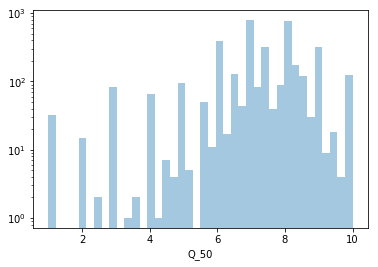

In [8]:
ax = sns.distplot(stats.Q_50, kde=False, bins=40, hist_kws={'log':True})

Train test split

In [9]:
# Split the data into a 70/30 split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(one.iloc[:,3:], one['Rating'], test_size=0.33, random_state=42)

In [10]:
X_train = one.iloc[:,3:]
Qone = X_train.multiply(stats.Q_50)
Qone.head(10)

,aaahhh,aarg,abbey,abilities,ability,able,aboms,about,above,absolute,...,youre,yourself,yr,yspahan,yup,zertz,zman,zombie,zombies,zooleretto
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
N_total = X_train.iloc[:,3:].sum(axis=1)
predictions = Qone.sum(axis=1)/N_total

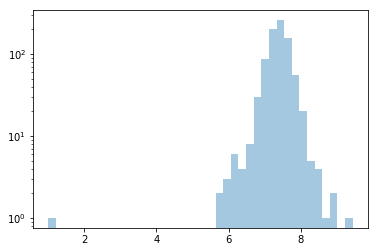

In [12]:
ax = sns.distplot(predictions, kde=False, bins=40, hist_kws={'log':True})

In [13]:
rmse_medians = rmse(one['Rating'], predictions)
display(Markdown(f"### Word Medians RMSE: {rmse_medians:.5f}"))

### Word Medians RMSE: 1.42387

An improvement of -0.28 RMSE rating

# 5. Vectorize

In [ ]:
model = Word2Vec(review['token'], size=100, window=5, min_count=5, workers=16, sg=0, negative=5)
vec_size = model.layer1_size
word_vectors = model.wv

In [ ]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

__Cosine Similarity Function__

$$ cos(\theta) = \frac{A \bullet B} {\Vert A \Vert \Vert B \Vert} =  \frac{\sum_{i=1}^n A_i B_i}{\sqrt{ \sum_{i=1}^n A^2} \sqrt{ \sum_{i=1}^n B^2}} $$

_Version A. Raw Code_

#### _Used the cosine similarity function to check common words. 'Easy' and 'Simple' appear to be much more similar than 'Cat'.<br> <br>A good sign that the vectorization worked!_

# 4. Word Embedding

In [ ]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

In [ ]:
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

In [ ]:
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in review['token']]

In [ ]:
# pad
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
y = pd.get_dummies(review['rating_normed']).values

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [ ]:
target_categorical_unique = len(review['rating'].unique())

In [ ]:
# NOTE: This code was from a tutorial and seems to be accounting for an error I can't find but in doing so creates a new error
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
# we initialize the matrix with random numbers
# NOTE: changed to nb_words+1 to account for index error, not sure why it broke in the first place
wv_matrix = (np.random.rand(nb_words+1, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        embedding_vector = word_vectors[word]
        wv_matrix[i] = embedding_vector
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        print('error')    

# 5. Models

In [ ]:
from keras.layers import Dense, Input, CuDNNLSTM, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

In [ ]:
wv_layer = Embedding(nb_words+1,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

In [ ]:
# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

In [ ]:
embedded_sequences = wv_layer(comment_input)

In [ ]:
# biGRU
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)

In [ ]:
# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(target_categorical_unique, activation='sigmoid')(x)

In [ ]:
# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['categorical_accuracy'])

In [ ]:
model.summary()

In [ ]:
hist = model.fit(X_train, y_train, validation_split=0.2,
                 epochs=2, verbose=1,shuffle=True)

In [ ]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(5,5));
plt.plot(history["loss"]);
# validation loss
plt.plot(history["val_loss"]);
plt.title("Loss with pretrained word vectors")
plt.legend()
plt.show();

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)

In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
predict = model.predict(X_test)

In [ ]:
def convert_to_one(p):
    new_p =[]
    for values in p:
        l = []
        max_index,_ = max(enumerate(values), key=operator.itemgetter(1))

        for m in range(len(values)):
            if m!=max_index:
                l.append(0)
            else:
                l.append(1)
        new_p.append(l)
        
    return new_p

In [ ]:
from keras.backend import argmax as kargmax
y_predict = np.argmax(predict,axis=1)
y_actual = np.argmax(y_test,axis=1)

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_actual[0:150],color='b')
plt.plot(y_predict[0:150],color='r')
plt.title('Neural Network Ratings Prediction')
plt.legend(['Actual','Predicted'])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion(y, y_pred, title):
    # rating levels
    ratings = list(range(1,11))

    # generate confusion matrix
    cm = confusion_matrix(y, y_pred)

    # normalize matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # plot matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.magma)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(ratings))
    plt.xticks(tick_marks, ratings, rotation=45)
    plt.yticks(tick_marks, ratings)
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('Actual rating')
    plt.xlabel('Predicted rating');

In [ ]:
plot_confusion(y_actual,y_predict,'LSTM NN')

## _Root Mean Squared Error_

$$ RMSE_{y} =  \sqrt{\frac{\sum_{i=1}^n {(\hat{y}_{i}- y_{i})}^2}{N}} $$

In [ ]:
RMSE = np.sqrt(np.sum(np.square(np.subtract(y_predict,y_actual)))/len(y_actual))
# print('Root Mean Squared Error: {}'.format(RMSE))

In [ ]:
print(RMSE)